In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import load_nyt_database, word_freq, GetTemporalNIH, GetTemporalNSF, GetTemporalPsyc, IsValidYear
import itertools
from matplotlib.ticker import ScalarFormatter, LogFormatterMathtext

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib inline

In [173]:
nyt = load_nyt_database()
psyc = GetTemporalPsyc()
nih = GetTemporalNIH()
nsf = GetTemporalNSF()
all_words = set(nsf.columns.tolist() + nih.columns.tolist() + psyc.columns.tolist() + nyt.columns.tolist())
words = [x for x in all_words if x!= "Total"]
books = word_freq(words)
books.rename(columns={k:k.strip() for k in books.columns}, inplace=True)

In [177]:
cultural_groups = {'bi': ['bicultural', 'biracial', 'biethnic', 'interracial'],
 'mixed': ['mixed race', 'mixed ethnicity', 'other race', 'other ethnicity'],
 'mono': ['monoracial', 'monoethnic', 'monocultural'],
 'multi': ['multiethnic', 'multicultural', 'multiracial', 'polycultural', 'polyethnic', 'polyracial'],
 'theory': ['multiculturalism', 'cultural pluralism', 'polyculturalism']}

In [191]:
for source, data in {"Books": books, "NYT": nyt, "Psyc":psyc, "NIH": nih, "NSF": nsf}.items():
  for k, v in cultural_groups.items():
    v = [v_ for v_ in v if v_ in data]
    data[k] = data[v].fillna(0).sum(axis=1)
    words.append(k)
words = set(words)

In [258]:
def plot_all(words, norm=True):
    df1 = books[words]
    y = df1
    if norm:
     y = y / y.mean()
    axis_1 = y.plot(figsize=(24,6))
    axis_1.set_title("Google Book Ngrams", fontsize=24)
    axis_1.set_xlabel("Year")
    _ = axis_1.legend(loc='upper left', ncol=2)
    axis_1.set_yscale('log') # You can disable
    if norm:
      axis_1.set_ylim(1e-2, 1e2) # You can disable
    axis_1.yaxis.set_major_formatter(LogFormatterMathtext())     
    axis_1.grid(True)
    axis_1.set_xlim(xmin=1800)
    axis_1.set_xlabel("Year", fontsize=20)
    axis_1.set_ylabel("Percentage of historical average", fontsize=20)

    y = nyt[words].rolling(window=10, center=False).mean()
    if norm:
     y = y/ y.mean()
    axis_2 = y.plot(figsize=(24,6))
    axis_2.set_title("New York Times", fontsize=24)
    axis_2.set_yscale('log') # You can disable
    axis_2.set_ylabel("Percentage of historical average", fontsize=20)
    axis_2.set_xlabel("Year", fontsize=20)
    if norm:
      axis_2.set_ylim(1e-2, 1e2) # You can disable
    else:
      axis_2.set_ylim(ymin=1e-7) # You can disable        
    axis_2.yaxis.set_major_formatter(LogFormatterMathtext())
    axis_2.grid(True)
    axis_2.set_xlim(xmin=1800)
    _ = axis_2.legend(loc='upper left', ncol=2)
    
    for title, data in {"Psyc Info Metadata":psyc, "NIH Grants": nih, "NSF Grants": nsf}.items():
        y = data[words]
        y = y.rolling(window=3, center=False).mean()
        if norm:
          y = y / y.mean()
        axis = y.plot(figsize=(24,6))
        axis.set_title(title, fontsize=24)
        axis.set_xlabel("Year", fontsize=20)
        axis.set_ylabel("Percentage of historical average", fontsize=20)
        #axis_3.set_yscale('log') # You can disable    
        axis.set_xlim(xmin=1850)
        axis.grid(True)
        _ = axis.legend(loc='upper left', ncol=2)
        

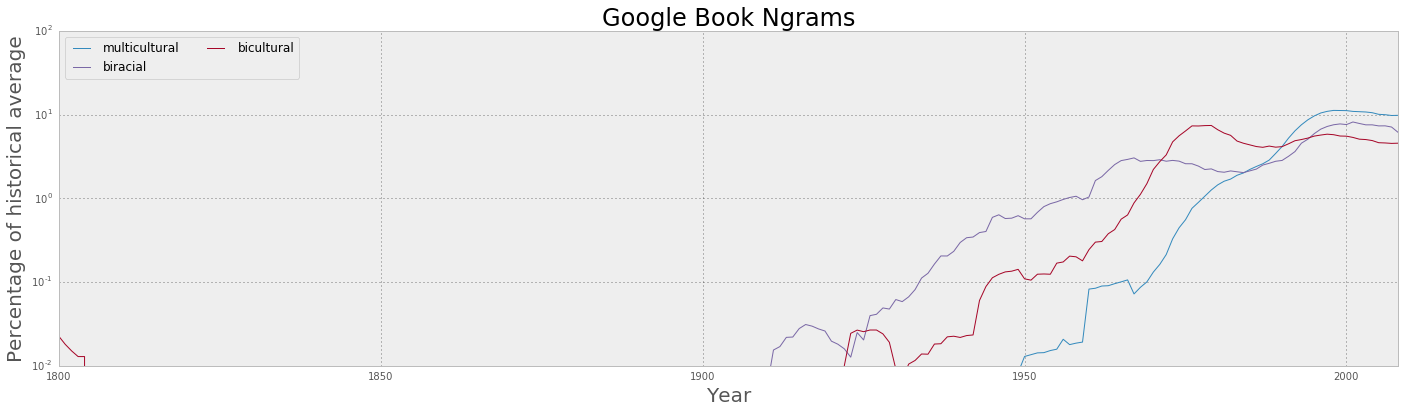

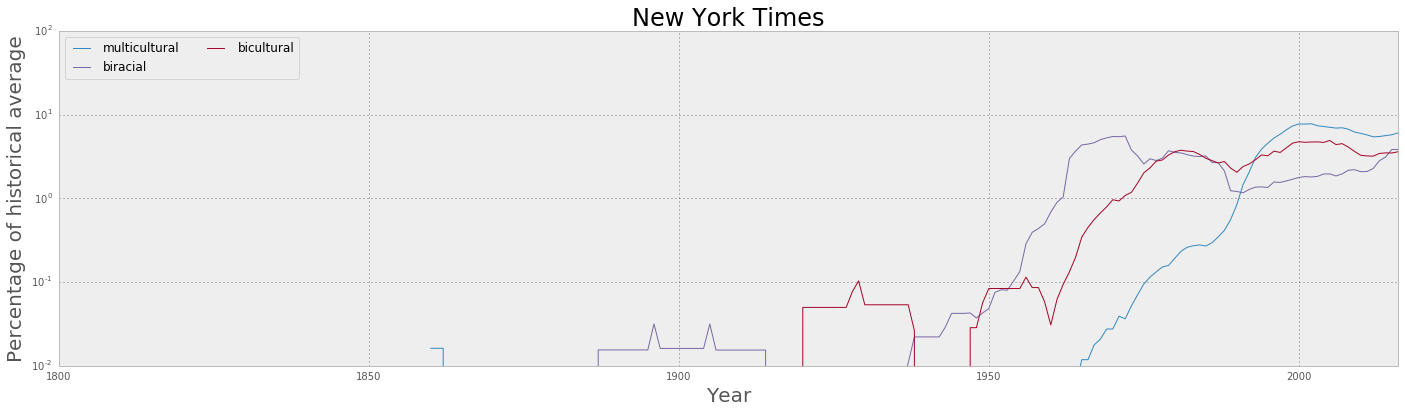

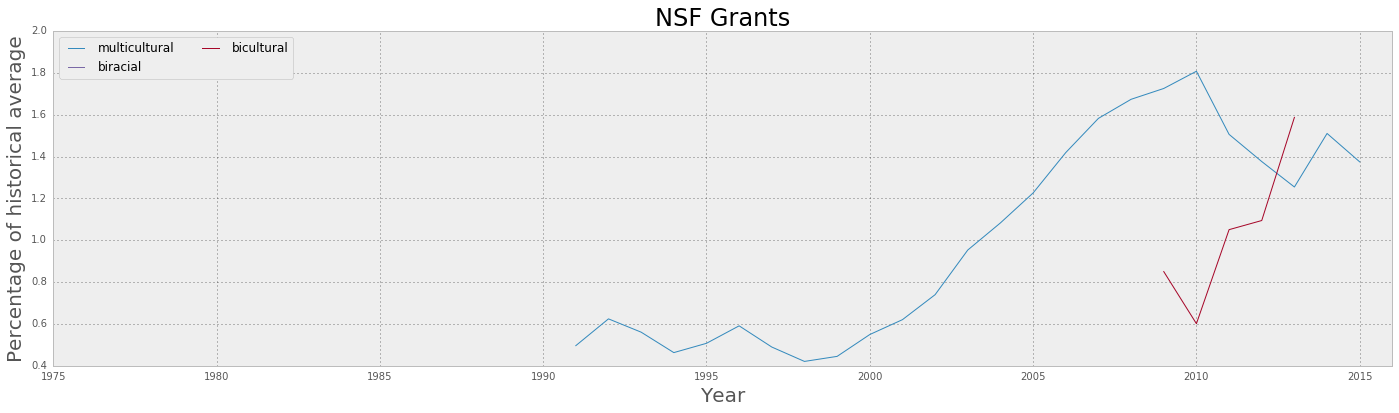

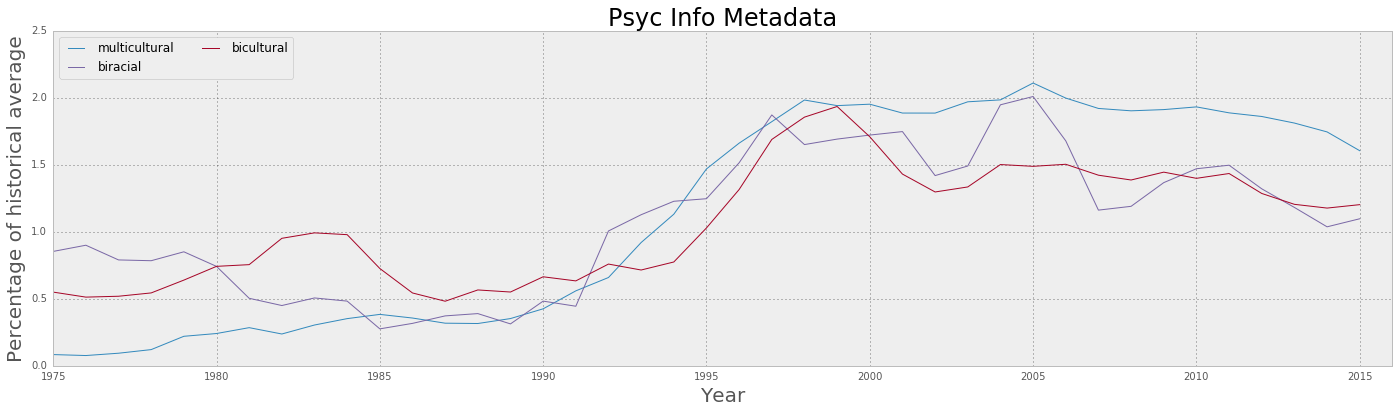

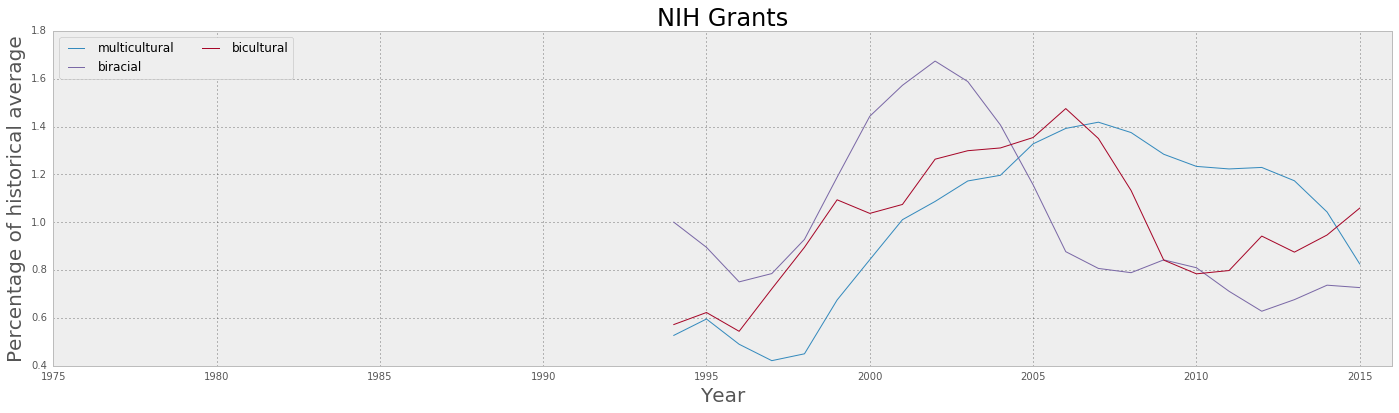

In [94]:
sample = ["multicultural", "biracial", "bicultural"]
plot_all(sample)

In [180]:
def StatsFromSeries(y):
    historical_avg = y.mean()
    #plt.plot(y.index, historical_avg)
    years1 = y[y > 0].index
    years2 = y[y > historical_avg].index
    years1 = np.nan if not len(years1) else int(years1[0]) 
    years2 = np.nan if not len(years2) else int(years2[0]) 
    record = {"First Appearance": years1,
              "Passed Hist Avg": years2,
              }
    return record

In [217]:
records = []

for source, data in {"Books": books, "NYT": nyt, "Psyc":psyc, "NIH": nih, "NSF": nsf}.items():
    for word in words:
      window = 5 if source not in {"NYT"} else 10
      if word not in data:
        print("{} is not found in {}".format(word, source))
        continue
      if source != "Books":
        y = data[word].rolling(window=window, center=False).mean()
      else:
        y = data[word]
      record = StatsFromSeries(y)
      record["Word"] = word
      record["Source"] = source
      records.append(record)
df = pd.DataFrame.from_dict(records)

polyethnic is not found in NSF
polyculturalism is not found in NSF
monoracial is not found in NSF
polyracial is not found in NSF
monoethnic is not found in NSF
biethnic is not found in NSF
polyethnic is not found in NIH
polyculturalism is not found in NIH
polycultural is not found in NIH
polyracial is not found in NIH
monoethnic is not found in NIH
polyracial is not found in Psyc
polyracial is not found in Books


In [218]:
df[df.Word == "multicultural"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
108,1804.0,1978.0,Books,multicultural
60,1860.0,1991.0,NYT,multicultural
84,1971.0,1995.0,Psyc,multicultural
35,1996.0,2003.0,NIH,multicultural
15,1993.0,2005.0,NSF,multicultural


In [219]:
df[df.Word == "biracial"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
111,1877.0,1957.0,Books,biracial
63,1887.0,1962.0,NYT,biracial
87,1968.0,1995.0,Psyc,biracial
38,1996.0,2000.0,NIH,biracial
18,NaN,NaN,NSF,biracial


In [220]:
df[df.Word == "mixed race"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
89,1800.0,1804.0,Books,mixed race
40,1860.0,1978.0,NYT,mixed race
65,1978.0,1996.0,Psyc,mixed race
20,2005.0,2012.0,NIH,mixed race
1,NaN,NaN,NSF,mixed race


In [221]:
df[df.Word == "monocultural"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
109,1897.0,1964.0,Books,monocultural
61,1963.0,1990.0,NYT,monocultural
85,1990.0,1999.0,Psyc,monocultural
16,1992.0,2003.0,NSF,monocultural
36,2004.0,2004.0,NIH,monocultural


In [222]:
df[df.Word == "monoracial"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
50,1967.0,1967.0,NYT,monoracial
99,1890.0,1985.0,Books,monoracial
75,1996.0,2009.0,Psyc,monoracial
27,NaN,NaN,NIH,monoracial


In [223]:
df[df.Word == "monoethnic"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
105,1902.0,1973.0,Books,monoethnic
57,1993.0,1993.0,NYT,monoethnic
81,2015.0,NaN,Psyc,monoethnic


## Cultural Groups

In [224]:
df[df.Word == "mono"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
91,1890.0,1965.0,Books,mono
67,1969.0,1981.0,Psyc,mono
42,1963.0,1990.0,NYT,mono
2,1988.0,1992.0,NSF,mono
21,2000.0,2001.0,NIH,mono


In [225]:
df[df.Word == "bi"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
69,1916.0,1916.0,Psyc,bi
93,1800.0,1934.0,Books,bi
44,1887.0,1950.0,NYT,bi
4,1971.0,1971.0,NSF,bi
23,1996.0,2000.0,NIH,bi


In [226]:
df[df.Word == "mixed"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
110,1800.0,1819.0,Books,mixed
62,1860.0,1868.0,NYT,mixed
86,1916.0,1916.0,Psyc,mixed
17,1970.0,1970.0,NSF,mixed
37,1996.0,2011.0,NIH,mixed


In [227]:
df[df.Word == "multi"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
96,1804.0,1975.0,Books,multi
47,1860.0,1976.0,NYT,multi
72,1946.0,1993.0,Psyc,multi
7,1972.0,1999.0,NSF,multi
26,1996.0,2003.0,NIH,multi


In [228]:
df[df.Word == "theory"].sort_values(by="Passed Hist Avg")

,First Appearance,Passed Hist Avg,Source,Word
106,1804.0,1971.0,Books,theory
58,1924.0,1991.0,NYT,theory
82,1940.0,1996.0,Psyc,theory
14,1991.0,1997.0,NSF,theory
33,1996.0,2008.0,NIH,theory


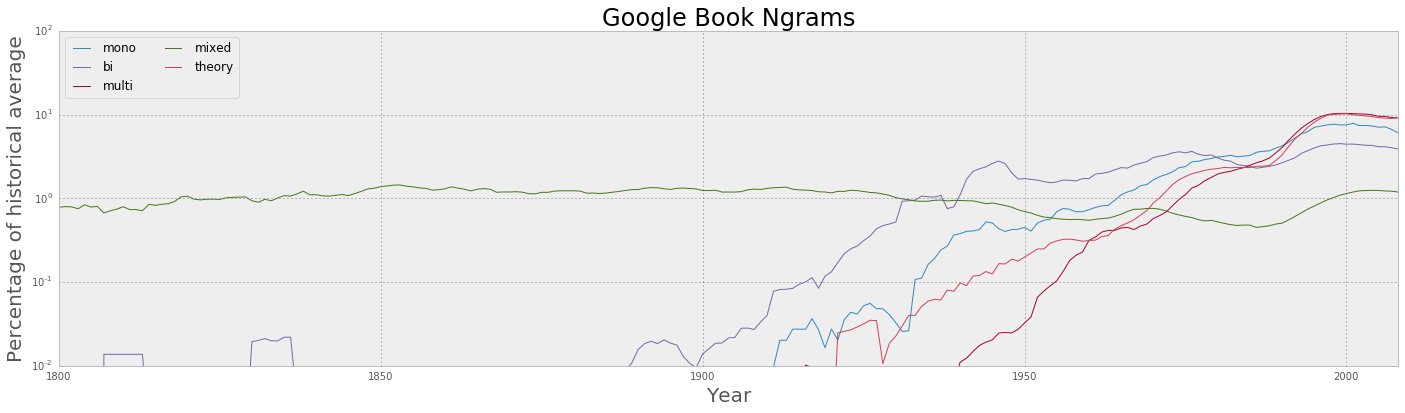

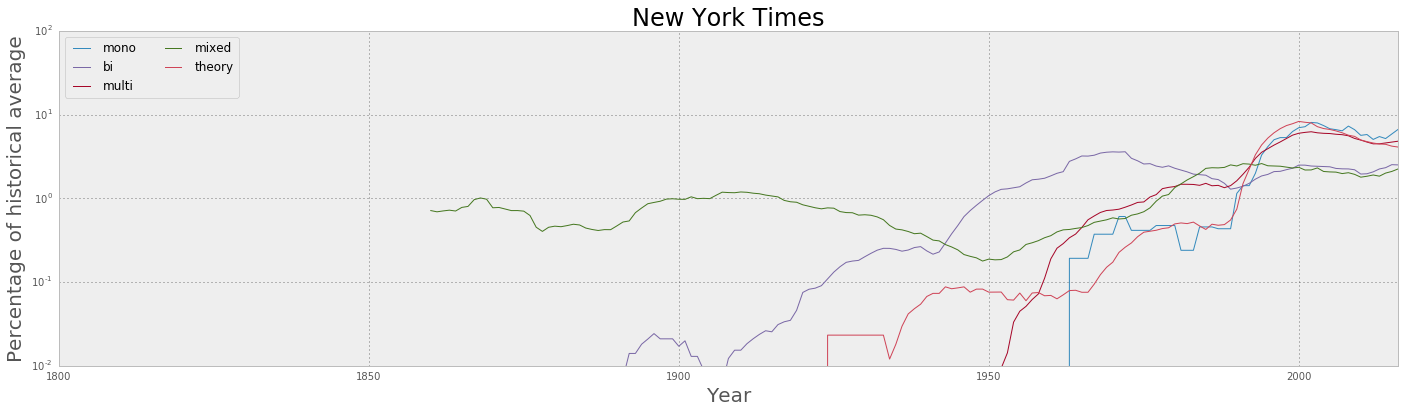

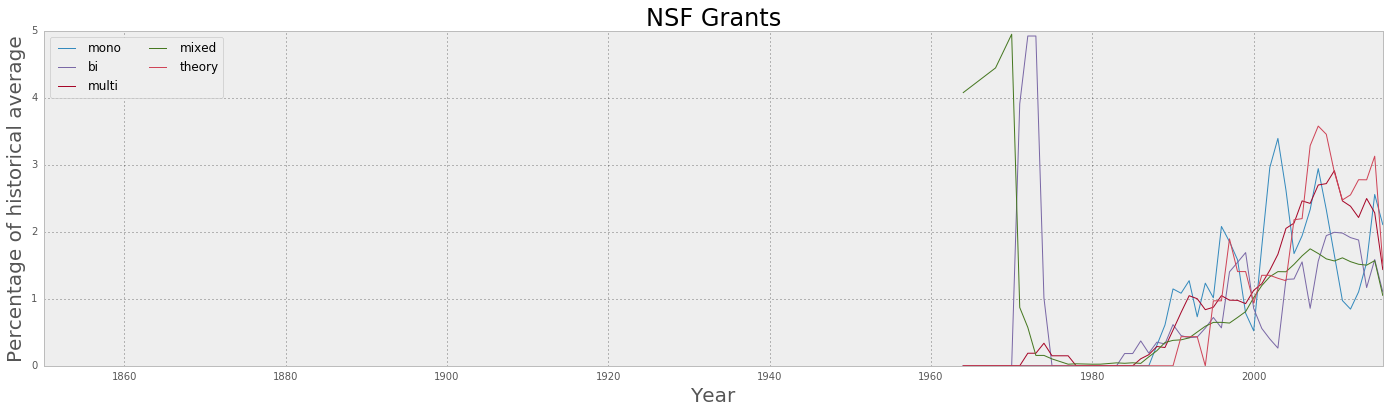

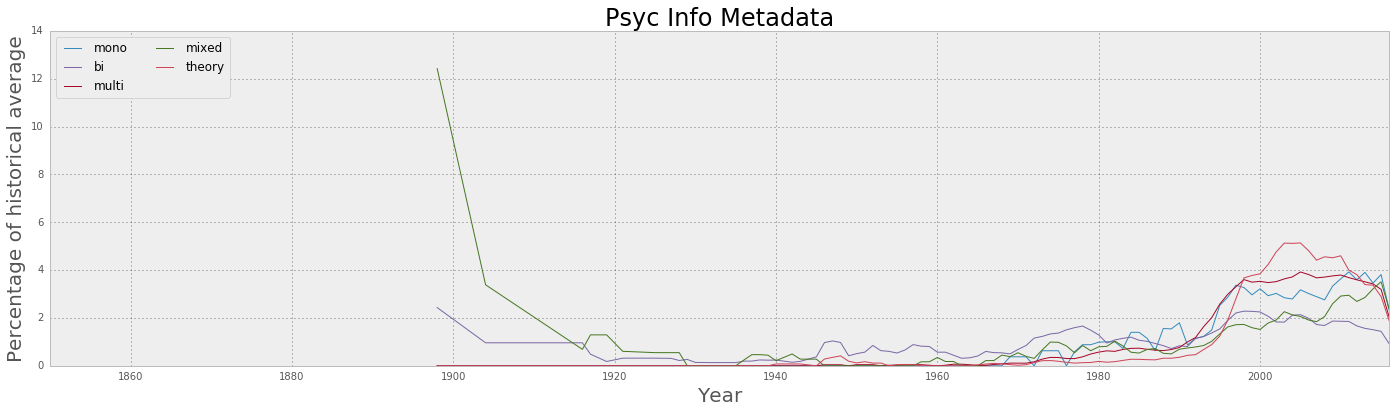

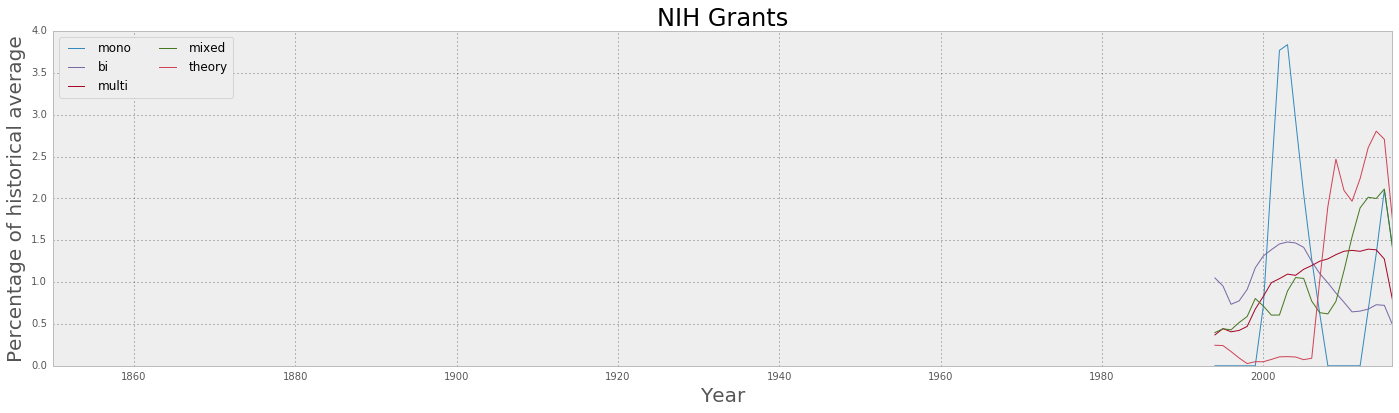

In [259]:
sample = ["mono", "bi", "multi", "mixed", "theory"]
plot_all(sample)

In [250]:
foo = psyc[psyc.index == 1850]
foo.values[foo.values.notnull()]

AttributeError: 'numpy.ndarray' object has no attribute 'notnull'

In [252]:
from tools import get_psycinfo_database
psycinfo = get_psycinfo_database()
total_pub = pd.DataFrame.from_csv("data/PsycInfo/PsycInfo Articles Review.csv")
total_pub["Year"] = [int(x) for x in total_pub.index.year]
total_pub.set_index("Year", inplace=True)
total_pub.rename(columns={"Articles": "Publications_Count"}, inplace=True)
clean_psycinfo = psycinfo[[IsValidYear(x) for x in psycinfo.Date.values]]
clean_psycinfo = clean_psycinfo.copy()
clean_psycinfo["Year"] = [int(x) for x in clean_psycinfo.Date]
clean_psycinfo["value"] = 1 
temporal_psyc = clean_psycinfo.pivot_table(index="Year", columns=["Term"], values="value", aggfunc=np.sum)
#total_counts = total_pub.loc[temporal_psyc.index]
#temporal_psyc.loc[temporal_psyc.index] = (temporal_psyc.values.T / total_counts.values.flatten()).T

